# Projet Atlas Investment Group 
Code pour mettre en place le dashbord qui permet l'analyse technique d'Atlas Invest group

## Mise en place environement de travail

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 22.3 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 41.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.0/508.0 kB 46.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-py3-none-any.whl size=138964 sha256=b16e565e45a2d1bd460dc11e44223b8555e69e9398abf96579ce6dcc1fd349af
  Stored in directory: /root/.cache/pip/wheels/ff/6c/15/506e25bc390de450a7fa53c155cd9b0fbd13ad3e84a9abc183
Successfully built peewee
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
  Attempting uni

In [2]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 71.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.4 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [4]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


## dashbord
Le code suivant permet de générer deux graphique pour l'aide à la décision : 
 - Le premier correspond à la prédiction cour terme fait par le model pré entrainer de Meta
 - Le second permet d'éfféctuer une analyse chartiste et tenter de détécter des signaux d'achat/vente en affichant les moyennes mobiles et le cours d'un asset

In [ ]:
# Fonction pour afficher et tenter de prédire le marché avec le model Prophet de Meta
def predict_and_plot(ticker, days_history=14, days_forecast=7):
    # Étape 1 : Télécharger les données
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - timedelta(days=days_history)).strftime('%Y-%m-%d')
    
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Préparer les données pour Prophet
    df = data.reset_index()[['Date', 'Close']]
    df.columns = ['ds', 'y']  # Prophet nécessite ces noms de colonnes
    
    # Étape 2 : Réinitialiser Prophet et ajuster le modèle
    model = Prophet(daily_seasonality=True)  # Nouvelle instance à chaque appel
    model.fit(df)
    
    # Étape 3 : Prédire les prochains jours
    future = model.make_future_dataframe(periods=days_forecast)
    forecast = model.predict(future)
    
    # Étape 4 : Combiner les données réelles et prédites
    df['type'] = 'Réel'
    forecast['type'] = 'Prédit'
    combined = pd.concat([df, forecast[['ds', 'yhat', 'type']].rename(columns={'yhat': 'y'})])
    
    # Étape 5 : Visualiser les données
    plt.figure(figsize=(10, 6))
    
    # Tracer le cours réel
    real_data = combined[combined['type'] == 'Réel']
    plt.plot(real_data['ds'], real_data['y'], label='Cours réel', color='blue', marker='o')
    
    # Tracer le cours prédit
    predicted_data = combined[combined['type'] == 'Prédit']
    plt.plot(predicted_data['ds'], predicted_data['y'], label='Cours prédit', color='orange', marker='o')
    
    # Ajouter une ligne de délimitation
    plt.axvline(x=real_data['ds'].iloc[-1], color='red', linestyle='--', label='Début des prédictions')
    
    # Ajouter des labels et une légende
    plt.title(f"Prévisions pour {ticker}")
    plt.xlabel('Date')
    plt.ylabel('Prix de clôture ($)')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Fonction pour afficher les moyennes mobiles et le cours d'un asset sur un graph
def plot_moving_averages(ticker, days_history=90, short_window=3, med_window=5, long_window=10):
    """
    Affiche le cours de l'action avec une moyenne mobile court terme et une moyenne mobile long terme.

    Args:
        ticker (str): Le symbole de l'action (ex: AAPL, MSFT).
        days_history (int): Nombre de jours d'historique à afficher.
        short_window (int): Fenêtre pour la moyenne mobile court terme.
        long_window (int): Fenêtre pour la moyenne mobile long terme.
    """
    # Étape 1 : Télécharger les données sur une période plus longue
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - timedelta(days=days_history)).strftime('%Y-%m-%d')
    
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Calcul des moyennes mobiles
    data['SMA_short'] = data['Close'].rolling(window=short_window).mean()  # Moyenne mobile court terme
    data['SMA_med'] = data['Close'].rolling(window=med_window).mean()  # Moyenne mobile court terme
    data['SMA_long'] = data['Close'].rolling(window=long_window).mean()    # Moyenne mobile long terme
    
    # Étape 2 : Visualiser les données
    plt.figure(figsize=(10, 6))
    
    # Tracer le cours de l'action
    plt.plot(data.index, data['Close'], label='Cours de l\'action', color='blue')
    
    # Tracer les moyennes mobiles
    plt.plot(data.index, data['SMA_short'], label=f'MM Court Terme ({short_window} jours)', color='red')
    plt.plot(data.index, data['SMA_med'], label=f'MM Moyen Terme ({med_window} jours)', color='orange')
    plt.plot(data.index, data['SMA_long'], label=f'MM Long Terme ({long_window} jours)', color='green')
    
    # Ajouter des labels et une légende
    plt.title(f"Cours et Moyennes Mobiles pour {ticker} (3 mois)")
    plt.xlabel('Date')
    plt.ylabel('Prix de clôture ($)')
    plt.legend()
    plt.grid()
    plt.show()

[*********************100%***********************]  1 of 1 completed
10:41:37 - cmdstanpy - INFO - Chain [1] start processing
10:41:37 - cmdstanpy - INFO - Chain [1] done processing


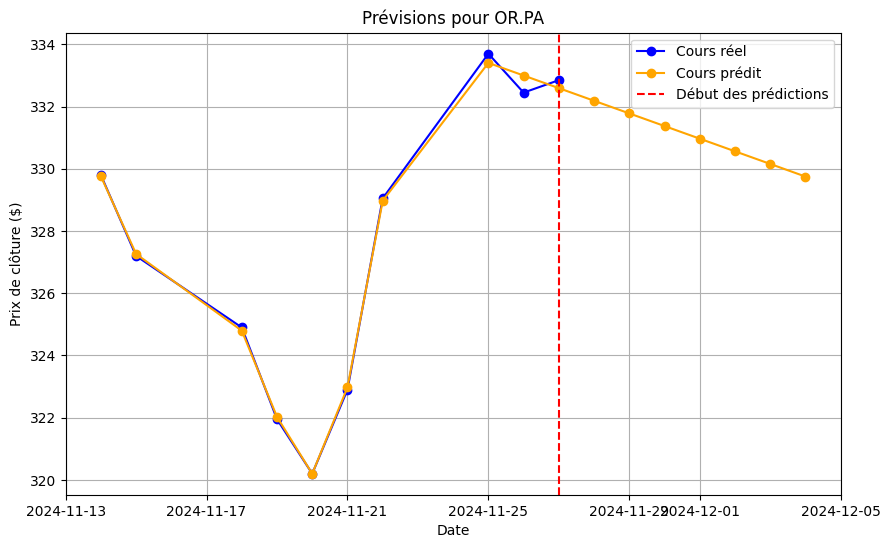

[*********************100%***********************]  1 of 1 completed


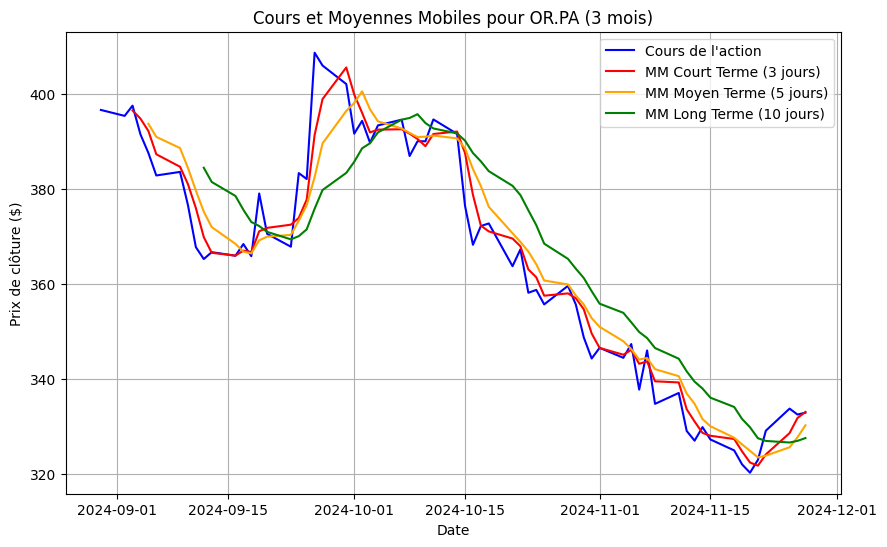

In [ ]:
# Exemple d'utilisation
ACTION = "OR.PA" # Action L'oréal
predict_and_plot(ACTION) 
plot_moving_averages(ACTION)